### **Import Required Libraries**

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

### **Data augmentation & Data Preparation (Training / Validation / Test Sets)**

In [19]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=15,
    zoom_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    "/content/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    "/content/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 21760 images belonging to 5 classes.
Found 2416 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


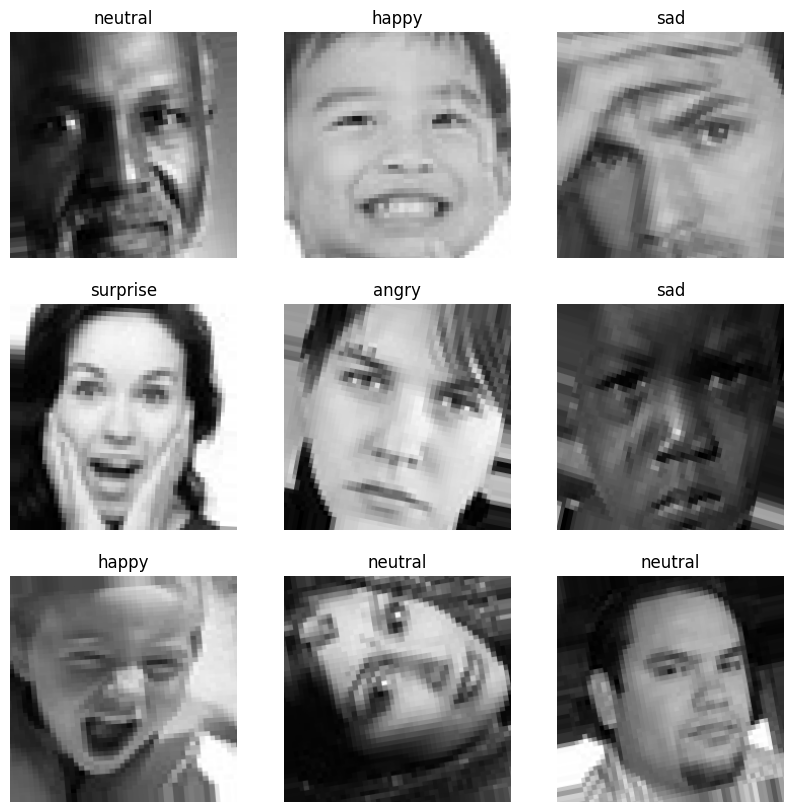

In [40]:
images, labels = next(train_generator)

class_names = list(train_generator.class_indices.keys())
labels = np.argmax(labels, axis=1)


plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.show()

### **Using MobileNetV2 for Transfer Learning**

In [20]:
NUM_CLASSES = train_generator.num_classes
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

### **Modify the Base Model: Cut & Add Custom Convolutional Layers**

#### **Freeze base model, extract intermediate layer, and add custom Conv layers**

In [21]:
cut_layer = base_model.get_layer('block_12_add')
x = cut_layer.output
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

### **Final Classification**


In [22]:
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,497,221 (9.53 MB)

 Trainable params: 1,936,773 (7.39 MB)

 Non-trainable params: 560,448 (2.14 MB)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

### **Compile and Train the Model (Initial Training)**

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4230 - loss: 2.1164

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


680/680 ━━━━━━━━━━━━━━━━━━━━ 285s 403ms/step - accuracy: 0.4231 - loss: 2.1157 - val_accuracy: 0.6068 - val_loss: 1.1622
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 269s 396ms/step - accuracy: 0.5943 - loss: 1.1360 - val_accuracy: 0.6010 - val_loss: 1.0765
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 284s 417ms/step - accuracy: 0.6239 - loss: 1.0355 - val_accuracy: 0.6387 - val_loss: 0.9709
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 264s 388ms/step - accuracy: 0.6371 - loss: 1.0022 - val_accuracy: 0.6279 - val_loss: 1.0018
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 277s 407ms/step - accuracy: 0.6688 - loss: 0.9493 - val_accuracy: 0.6643 - val_loss: 0.9132
Epoch 6/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 269s 396ms/step - accuracy: 0.6805 - loss: 0.9085 - val_accuracy: 0.6055 - val_loss: 1.0249
Epoch 7/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 279s 410ms/step - accuracy: 0.6944 - loss: 0.8688 - val_accuracy: 0.7016 - val_loss: 0.8407
Epoch 8/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 268s 393ms/step - accuracy: 0.7055 - loss: 0.84

### **Fine-Tune the Model (Unfreeze Top Layers)**

In [26]:
base_model.trainable = True
fine_tune_at = 60
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [27]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 296s 403ms/step - accuracy: 0.6864 - loss: 0.8973 - val_accuracy: 0.6767 - val_loss: 0.8902
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 269s 396ms/step - accuracy: 0.7254 - loss: 0.7758 - val_accuracy: 0.7041 - val_loss: 0.8048
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 270s 397ms/step - accuracy: 0.7596 - loss: 0.7005 - val_accuracy: 0.7103 - val_loss: 0.7858
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 270s 398ms/step - accuracy: 0.7704 - loss: 0.6676 - val_accuracy: 0.7111 - val_loss: 0.8019
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 274s 402ms/step - accuracy: 0.7818 - loss: 0.6313 - val_accuracy: 0.7260 - val_loss: 0.7621
Epoch 6/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 321s 402ms/step - accuracy: 0.7936 - loss: 0.5901 - val_accuracy: 0.7210 - val_loss: 0.7619
Epoch 7/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 274s 403ms/step - accuracy: 0.8112 - loss: 0.5543 - val_accuracy: 0.7161 - val_loss: 0.8100
Epoch 8/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 272s 400ms/step - accuracy: 0.8257 -

### **Evaluate on the test set**

In [29]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

  1/189 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.7188 - loss: 0.7503

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7503 - loss: 0.6871
Test Loss: 0.7602
Test Accuracy: 0.7281


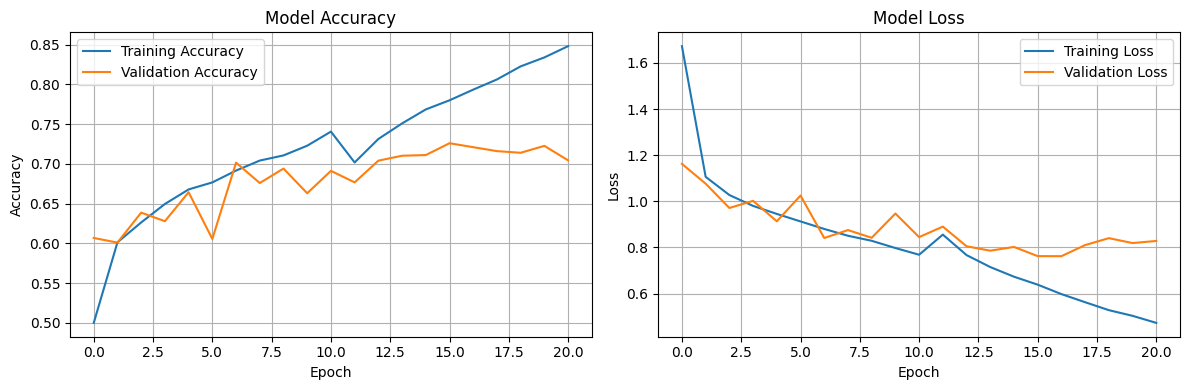

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


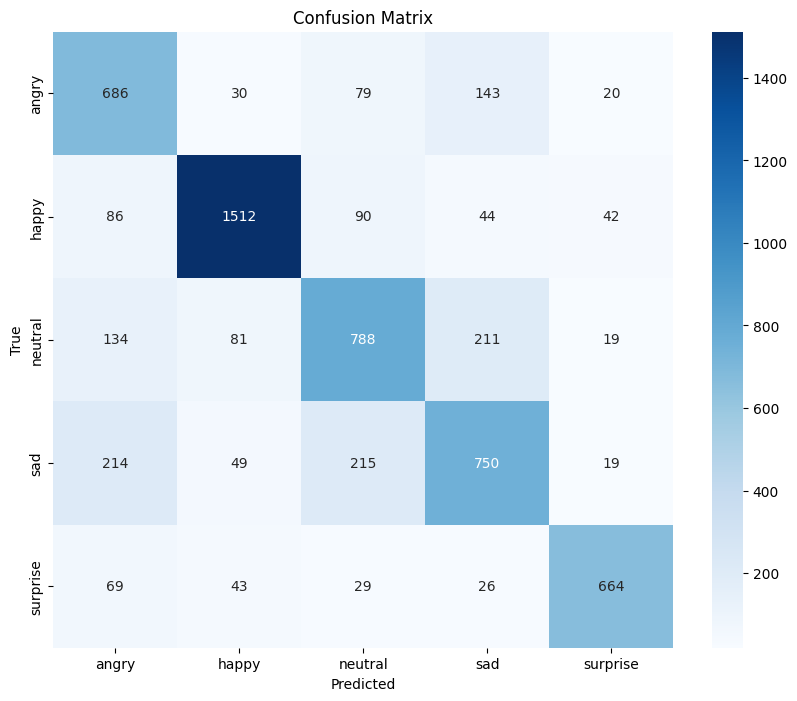

In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
model.save("emotion_model.h5")

In [42]:
from google.colab import files
files.download("emotion_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/content/4.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = np.argmax(pred)

class_labels = list(train_generator.class_indices.keys())
print("Predicted Emotion:", class_labels[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: sad


In [39]:
import numpy as np
class_labels = list(train_generator.class_indices.keys())
np.save("labels.npy", class_labels)
files.download("labels.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>